In [14]:
import pickle
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import torch
import torch.distributions as dist

from pybpl.library import Library

# Load spline data

In [15]:
with open('../substroke_dict.p', 'rb') as fp:
    ss_dict = pickle.load(fp)

with open('../spline_dict.p', 'rb') as fp:
    spline_dict = pickle.load(fp)

In [16]:
def flatten_spline_dict(ss_dict, spline_dict):
    splines = []
    n_alpha = len(ss_dict)
    for a in range(n_alpha):
        alphabet = ss_dict[a]
        n_char = len(alphabet)
        for c in range(n_char):
            char = alphabet[c]
            n_rend = len(char)
            for r in range(n_rend):
                rendition = char[r]
                n_stroke = len(rendition)
                for s in range(n_stroke):
                    stroke = rendition[s]
                    n_substrokes = len(stroke)
                    for ss in range(n_substrokes):
                        num_steps = len(stroke[ss])
                        if num_steps >= 10:
                            splines.append(spline_dict[a][c][r][s][ss])
                            
    return np.asarray(splines, dtype=np.float32)

In [17]:
splines = flatten_spline_dict(ss_dict, spline_dict)

In [19]:
X = torch.tensor(splines)

In [20]:
X.shape

torch.Size([61950, 6, 2])

# Load BPL library data

In [8]:
lib = Library(lib_dir='../../../lib_data/')

# shapes params
shapes_mu = lib.shape['mu']
shapes_cov = lib.shape['Sigma']

# scales params
scales_theta = lib.scale['theta']
scales_con = scales_theta[:,0]  # gamma concentration
scales_rate = 1 / scales_theta[:,1]  # gamma rate

# get distributions for each subid
mvns = []
gammas = []
for subid in range(1212):
    mvn = dist.MultivariateNormal(shapes_mu[subid], shapes_cov[subid])
    gamma = dist.Gamma(scales_con[subid], scales_rate[subid])
    mvns.append(mvn)
    gammas.append(gamma)

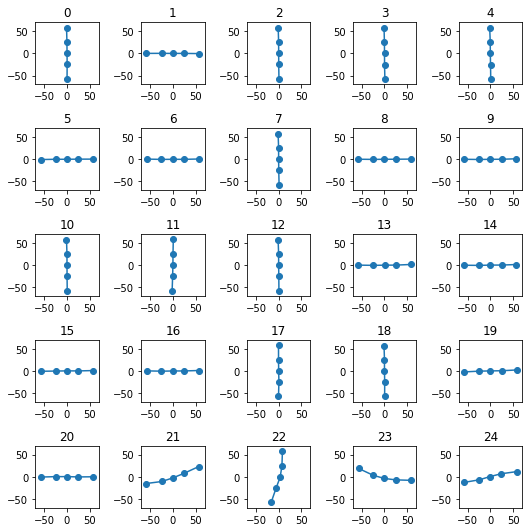

In [26]:
nrow = 5
ncol = 5
fig, axes = plt.subplots(nrow,ncol,figsize=(1.5*ncol,1.5*nrow))
for i in range(nrow):
    for j in range(ncol):
        ix = i*ncol + j
        cpts = shapes_mu[ix].numpy().reshape(5,2)
        axes[i,j].plot(cpts[:,0], cpts[:,1])
        axes[i,j].scatter(cpts[:,0], cpts[:,1])
        axes[i,j].set_xlim(-70,70)
        axes[i,j].set_ylim(-70,70)
        axes[i,j].set_title(ix)
plt.tight_layout()
plt.show()

In [27]:
def score(x, subid):
    assert x.shape == torch.Size([6,2])
    scale = x[-1,0]
    cpts = x[:5].view(-1)
    log_prob = mvns[subid].log_prob(cpts) + gammas[subid].log_prob(scale)
    
    return log_prob

In [28]:
def predict(x):
    scores = np.zeros(len(shapes_mu), dtype=np.float32)
    for i in range(len(shapes_mu)):
        scores[i] = score(x, subid=i)
        
    return np.argmax(scores)

In [29]:
for i in range(20):
    print('i: %i'%i)
    print('pred: %i' % predict(X[i]))
    print('')

i: 0
pred: 598

i: 1
pred: 1012

i: 2
pred: 844

i: 3
pred: 601

i: 4
pred: 591

i: 5
pred: 1012

i: 6
pred: 1088

i: 7
pred: 1012

i: 8
pred: 598

i: 9
pred: 452

i: 10
pred: 1012

i: 11
pred: 1012

i: 12
pred: 452

i: 13
pred: 601

i: 14
pred: 1012

i: 15
pred: 601

i: 16
pred: 1012

i: 17
pred: 601

i: 18
pred: 601

i: 19
pred: 598

